In [1]:
# import the needed packages and librairies
import sys
import os
from datetime import date
sys.path.append('../')
from LIB.utils import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
import lightgbm as lgb

In [4]:
# read all the datasets files
DATA_PATH = './data/'
train = pd.read_csv(DATA_PATH+'Train.csv')
test = pd.read_csv(DATA_PATH+'Test.csv')
columns = pd.read_csv(DATA_PATH+'VariableDefinitions.csv')
drivers = pd.read_csv(DATA_PATH+'Riders.csv')

In [30]:
# merge drivers's informations with the train and test datasets
train = train.merge(drivers, on='Rider Id', how='left')
test = test.merge(drivers, on='Rider Id', how='left')
train['train'] = 1
test['train'] = 0

In [31]:
# this is a function that gives a quick review about the data
data_characterization(train)

shape of data : (21201, 34)


,Columns name,Type,Count unique values,Count Nan values,Ratio Nan values,Unique values,Max,Min,Mean
0,Order No,object,21201,0,0.0000,"[Order_No_4211, Order_No_25375, Order_No_1899,...",0.0000,0.0000,0.0000
1,User Id,object,3186,0,0.0000,"[User_Id_633, User_Id_2285, User_Id_265, User_...",0.0000,0.0000,0.0000
2,Vehicle Type,object,1,0,0.0000,[Bike],0.0000,0.0000,0.0000
3,Platform Type,int64,4,0,0.0000,"[3, 1, 2, 4]",4.0000,1.0000,2.7522
4,Personal or Business,object,2,0,0.0000,"[Business, Personal]",0.0000,0.0000,0.0000
5,Placement - Day of Month,int64,31,0,0.0000,"[9, 12, 30, 15, 13, 14, 11, 23, 2, 25, 19, 28,...",31.0000,1.0000,15.6537
6,Placement - Weekday (Mo = 1),int64,7,0,0.0000,"[5, 2, 1, 3, 4, 6, 7]",7.0000,1.0000,3.2401
7,Placement - Time,object,15686,0,0.0000,"[9:35:46 AM, 11:16:16 AM, 12:39:25 PM, 9:25:34...",0.0000,0.0000,0.0000
8,Confirmation - Day of Month,int64,31,0,0.0000,"[9, 12, 30, 15, 13, 14, 11, 23, 2, 25, 19, 28,...",31.0000,1.0000,15.6538
9,Confirmation - Weekday (Mo = 1),int64,7,0,0.0000,"[5, 2, 1, 3, 4, 6, 7]",7.0000,1.0000,3.2402


only temperature and precipitaion columns have missing values. we have to deal with them before the modeling part.

In [36]:
# grouping the features that need the same preprocessing
time = ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time']
targetFeatures = ['Arrival at Destination - Time', 'Arrival at Destination - Day of Month', 
                  'Arrival at Destination - Weekday (Mo = 1)']#, 'mean_speed_km/h', 'TimeHours','daysArrival']
toDrop = ['Order No', 'User Id', 'Vehicle Type', 'Rider Id', 'train', 'No_of_Ratings']

In [32]:
# converting the time features to datetime type and extraction the hour, minute and second features
for c in time:
    print(c)
    # extracting the hour
    train[c+'Hour'] = pd.to_datetime(train[c]).dt.hour
    test[c+'Hour'] = pd.to_datetime(test[c]).dt.hour
    # extracting the minutes
    train[c+'minutes'] = pd.to_datetime(train[c]).dt.minute
    test[c+'minutes'] = pd.to_datetime(test[c]).dt.minute
    # extracting the seconds
    train[c+'seconds'] = pd.to_datetime(train[c]).dt.second
    test[c+'seconds'] = pd.to_datetime(test[c]).dt.second

Placement - Time
Confirmation - Time
Arrival at Pickup - Time
Pickup - Time


In [37]:
# extracting the target column and the train dataset
y = train['Time from Pickup to Arrival']
X_test = test.drop(time+toDrop, axis=1)
X = train.drop(time+targetFeatures+toDrop+['Time from Pickup to Arrival'], axis=1)

In [38]:
# fillna the nan values
X['Precipitation in millimeters'].fillna(0, inplace=True)
X_test['Precipitation in millimeters'].fillna(0, inplace=True)
X['Temperature'].fillna(X['Temperature'].mean(), inplace=True)
X_test['Temperature'].fillna(X_test['Temperature'].mean(), inplace=True)

In [39]:
# features to encode
toEncodeLabels = ['Personal or Business','Placement am-pm', 'Arrival at Pickup am-pm', 'Addr_typePickup',
                 'SubregionPickup', 'SubregionDestination'] #'CityDestination', 'CityPickup'
Xnew, l = Label_encoder(X)
Xtest, ltest = Label_encoder(X_test)

In [43]:
params = {'num_leaves': 21,
         'min_data_in_leaf': 20,
         'objective':'regression',
         'learning_rate': 0.001,
         'max_depth': 250,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "random_state": 42,
         #"categorical_feature":toEncodeLabels
         }


def lgb_base_model(X, y, testX, submissionName='submission_lgb.csv'):
    """
    This is a function that trains a light-gbm model with the provided parameters using the k-fold strategy
    and predict the values for the test data set. The predicted values will be stores 
    Arguments:
        - X: the train data set
        - y: the target variable
        - testX: the test data set 
        - submissionName: the submission name that will be stores in 

    Returns:
        - features importance
    """
    # list to gather the root mean squared errors for each fold
    rmses = []
    # read the submission file
    submission = pd.read_csv(DATA_PATH+'SampleSubmission.csv')
    predictions = np.zeros(len(testX))

    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y.values)):
        print('working fold %d' % fold_)
        strLog = "fold {}".format(fold_)
        print(strLog)

        X_tr, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[trn_idx], y.iloc[val_idx]
        # train the light gbm model
        model = lgb.LGBMRegressor(**params, n_estimators=85000, n_jobs=-1)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='rmse',
                  verbose=1000, early_stopping_rounds=500)

        # predictions
        preds = model.predict(testX, num_iteration=model.best_iteration_)
        predictions += preds / folds.n_splits
        preds = model.predict(X_val, num_iteration=model.best_iteration_)


        # root mean squared error
        rmse = sqrt(mean_squared_error(y_val, preds))
        print('RMSE: %.6f' % rmse)
        rmses.append(rmse)

        fold_importance_df['importance_%d' % fold_] = model.feature_importances_[:len(X.columns)]


    print('RMSEs', rmses)
    print('RMSE mean: %.6f' % np.mean(rmses))

    submission['Time from Pickup to Arrival'] = round(predictions)
    # check if the submission folder exists. If not, create it.
    if os.path.exists('../submission/'):
        os.mkdir('../submission/')
    submission.to_csv('../submission/{}'.format(submissionName), index=False)
    fold_importance_df.to_csv('fold_imp_lgb.csv', index=False)
    return fold_importance_df

In [44]:
# train the model, make submissions and get the features's importance
fold_importance_df = lgb_base_model(Xnew, y, Xtest)

working fold 0
fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's rmse: 814.035	valid_1's rmse: 820.808
[2000]	training's rmse: 768.416	valid_1's rmse: 783.639
[3000]	training's rmse: 748.462	valid_1's rmse: 772.168
[4000]	training's rmse: 734.929	valid_1's rmse: 766.678
[5000]	training's rmse: 723.553	valid_1's rmse: 763.03
[6000]	training's rmse: 713.627	valid_1's rmse: 760.431
[7000]	training's rmse: 704.673	valid_1's rmse: 758.444
[8000]	training's rmse: 696.374	valid_1's rmse: 756.972
[9000]	training's rmse: 688.67	valid_1's rmse: 755.922
[10000]	training's rmse: 681.307	valid_1's rmse: 755.063
[11000]	training's rmse: 674.296	valid_1's rmse: 754.25
[12000]	training's rmse: 667.623	valid_1's rmse: 753.65
[13000]	training's rmse: 661.116	valid_1's rmse: 753.087
[14000]	training's rmse: 654.844	valid_1's rmse: 752.717
[15000]	training's rmse: 648.803	valid_1's rmse: 752.298
[16000]	training's rmse: 642.848	valid_1's rmse: 751.925
[17000]	training

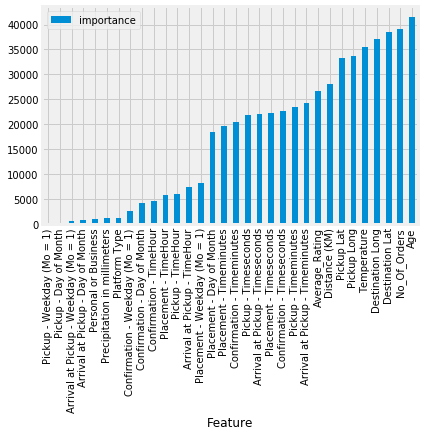

In [46]:
# plot the featues based on their importance
fold_importance_df['importance'] = fold_importance_df.drop('Feature', axis=1).sum(axis = 1)/fold_importance_df.shape[1]
fold_importance_df[['Feature','importance']].sort_values(by='importance').plot(x='Feature', y='importance', kind='bar')